In [1]:
import xcc
xcc.Settings(REFRESH_TOKEN="eyJhbGciOiJIUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICIwYTdjOGE5Yi1lMzdkLTQ0MzItOTU2OC0xNzI3YzEwNmYyMzEifQ.eyJpYXQiOjE2NjEyNTk0MDYsImp0aSI6IjA4OTVkYWE1LWFmOTYtNGQ1Ni05NDg0LTE4Yjk3Mjk1MTY4MCIsImlzcyI6Imh0dHBzOi8vcGxhdGZvcm0ueGFuYWR1LmFpL2F1dGgvcmVhbG1zL3BsYXRmb3JtIiwiYXVkIjoiaHR0cHM6Ly9wbGF0Zm9ybS54YW5hZHUuYWkvYXV0aC9yZWFsbXMvcGxhdGZvcm0iLCJzdWIiOiJlOGUwZjA5Mi0zZTNlLTQwNjYtYjZmMC02MGU2ZWM5NDk5M2UiLCJ0eXAiOiJPZmZsaW5lIiwiYXpwIjoicHVibGljIiwic2Vzc2lvbl9zdGF0ZSI6IjA2NDQwMzk2LWU0YjgtNDJhZi1hMjM5LTk4YzgxZjViNmI3YSIsInNjb3BlIjoicHVibGljLXJvbGVzIHByb2ZpbGUgZW1haWwgb2ZmbGluZV9hY2Nlc3MiLCJzaWQiOiIwNjQ0MDM5Ni1lNGI4LTQyYWYtYTIzOS05OGM4MWY1YjZiN2EifQ.eNqsxqnW_SZRDArqjI3lfamj0SaijF6XBeAfLUqnbVE").save()


In [2]:
import xcc.commands
xcc.commands.ping()

'Successfully connected to the Xanadu Cloud.'

### Define functions that outputs a random number & von neuman post-processing
```qrng_func()``` and ```von_neuman_post_proc(a,b)```, respectively.
We work with $4$ modes and our initial state is $|1101\rangle$.
We pass it through $6$ modes beam splitters measure the outputs at the end. Here, we count the number of photons in each mode.

Here we have used a simulated boson sampler to run the process. To run the same on the Xanadu boson sampler available on the cloud, include the code ```eng = sf.RemoteEngine("X8")```

In [3]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
n_modes = 4     # number of modes

# define a function that outputs a random number
def qrng_func():
    prog = sf.Program(n_modes)
    eng = sf.Engine("fock", backend_options={"cutoff_dim": 6})
    #eng = sf.RemoteEngine("X8")
    with prog.context as q:
        Fock(1) | q[0]
        Fock(1) | q[1]
        Vac | q[2]
        Fock(1) | q[3]
        BSgate()  | (q[0], q[1])
        BSgate()  | (q[1], q[2])
        BSgate()  | (q[2], q[3])
        BSgate()  | (q[0], q[1])
        BSgate()  | (q[1], q[2])
        BSgate()  | (q[2], q[3])
        MeasureFock() | (q[0], q[1], q[2], q[3])

    results = eng.run(prog)
    return(results.samples)

#define function for von neuman post-processing
def von_neuman_post_proc(a,b):
    c = []
    for i in range(len(a)):
        if a[i] < b[i]:
            c.append(1)
        elif a[i] > b[i]:
            c.append(0)
    
    number = str()
    if len(c) == 0:
        number = str(0)
    else:
        for i in range(len(c)):
            number = number + str(c[i])
    return number        # output is a binary string

### Obtain a random number
```sample1``` and ```sample2``` are the outputs from two measurements.
To generate an unbiased random string of $1$s and $0$s, we perform von neuman post-processing.

In [4]:
r1 = qrng_func()
r2 = qrng_func()
sample1 = r1[0].tolist()     #Sample 1
sample2 = r2[0].tolist()     #Sample 2

# print the samples
print(sample1)
print(sample2)

# obtain random number (binary) after von neuman post processing
number = von_neuman_post_proc(sample1, sample2)
decimal_number = int(number,2)
print('')
# print random numer in binary
print('A random number in binary basis is :', number )      
# print that random numer in decimal
print('The random number in decimal is :', decimal_number )

[0, 1, 0, 2]
[0, 0, 3, 0]

A random number in binary basis is : 010
The random number in decimal is : 2


### Increase the range of random numbers using samples with more than 4 bits
This is done to obtain random numbers from a broader range. We can extend by using more bits. Below is an example using 8 bits

In [5]:
# increase the span of random numbers using samples with more than 4 bits

sample1_8bit = qrng_func()[0].tolist() + qrng_func()[0].tolist()
sample2_8bit = qrng_func()[0].tolist() + qrng_func()[0].tolist()
# print the samples
print(sample1_8bit)
print(sample2_8bit)

number = von_neuman_post_proc(sample1_8bit, sample2_8bit)
decimal_number = int(number,2)
print('')
# print random numer in binary
print('A random number in binary basis is :', number )      
# print that random numer in decimal
print('The random number in decimal is :', decimal_number )

[0, 0, 1, 2, 1, 0, 2, 0]
[1, 1, 0, 1, 0, 2, 0, 1]

A random number in binary basis is : 11000101
The random number in decimal is : 197


### Repeat this process many times to build up a distribution of the samples.
Obtain the Shannon entropy of the distribution.

Random numbers: [5, 1, 14, 9, 2, 0, 6, 3, 12, 4, 10]
Corresponding probabilities: [0.06, 0.3, 0.01, 0.01, 0.27, 0.09, 0.06, 0.08, 0.04, 0.04, 0.04]

The entropy of the distribution is : 1.9494630227318759


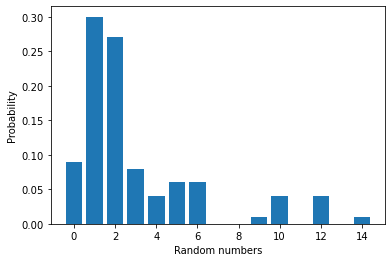

In [6]:
# Now make a list of random numbers which are outputs of our code,
# to obtain the probabilities and entropy
L = []
number_of_iterations = 100
for i in range(number_of_iterations):
    sample1 = qrng_func()[0].tolist()     #Sample 1
    sample2 = qrng_func()[0].tolist()     #Sample 2
    number = von_neuman_post_proc(sample1, sample2)
    decimal_number = int(number,2)
    L.append(decimal_number)
#L = list of random outputs

from collections import Counter
counts = Counter(L)
# list containing random numbers and number of occurances
mylist = np.array(list(counts.items()))    

x = []
y = []
for i in range(len(mylist)):
    x.append(mylist[i][0])
    y.append(mylist[i][1]/number_of_iterations)
import matplotlib.pyplot as plt
#plt.hist(counts)
plt.bar(x,y)
plt.xlabel('Random numbers')
plt.ylabel('Probability')
print('Random numbers:', x)         # random numbers
print('Corresponding probabilities:', y)         # corresponding probabilities
print('')
from scipy.stats import entropy
print('The entropy of the distribution is :', entropy(y))       # entropy